<a href="https://colab.research.google.com/github/skywalker0803r/deep-learning-ian-goodfellow/blob/master/offline%20DDPG%20general%20form.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.optim import Adam
import pandas as pd
from torch.utils.data import TensorDataset,DataLoader

# config

In [2]:
data_size = 10000 
batch_size = 256 
hidden_size = 128
state_size = 2 # 狀態不可控制 
request_size = 1 # 需求產出
value_size = 1 # 實際產出
action_size = 10  #可控制器數量
time_step = 6 #時間窗格

# data

In [3]:
data = {}
data['state'] = torch.rand(data_size,time_step,state_size)#(B,T,s_dim)
data['request'] = torch.rand(data_size,request_size)#(B,r_dim)
data['action'] = torch.rand(data_size,time_step,action_size)#(B,T,a_dim)
data['value'] = torch.rand(data_size,value_size)#(B,v_dim)
data = TensorDataset(data['state'],data['request'],data['action'],data['value'])
train_iter = DataLoader(data,batch_size,shuffle=False)

# R2D2 MODEL

In [4]:
class R2D2(nn.Module):
  def __init__(self,obs_size,n_actions,hidden_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.l1 = nn.Linear(obs_size,self.hidden_size)
    self.l2 = nn.LSTMCell(self.hidden_size,self.hidden_size)
    self.l3 = nn.Linear(self.hidden_size,n_actions)
  
  def forward(self,x,hx,cx):
    x = torch.tanh(self.l1(x))
    hx,cx = self.l2(x,(hx,cx))
    x = torch.tanh(hx)
    x = torch.sigmoid(self.l3(x)) # to range[0,1]
    return x,hx,cx

# ActorCritic Model

In [5]:
class ActorCritic(nn.Module):
  def __init__(self,actor,critic,time_step):
    super().__init__()
    self.time_step = time_step
    
    self.actor = actor
    self.actor_optimizer = Adam(actor.parameters())
    
    self.critic = critic
    self.critic_optimizer = Adam(critic.parameters())
  
  def forward(self):
    raise NotImplementedError

  def actor_forward(self,state,request,eval=False):
    
    # train or eval model
    if eval == True:
      self.actor.eval()
    else:
      self.actor.train()
    
    # initialize hx,cx
    hx = torch.zeros((state.size()[0],actor.hidden_size))
    cx = torch.zeros((state.size()[0],actor.hidden_size))
    
    # get actions shape(batch_size,time_step,action_size)
    actions = torch.FloatTensor()
    for t in range(self.time_step):
      a,hx,cx = self.actor(torch.cat((state[:,t,:],request),dim=1),hx,cx)
      actions = torch.cat((actions,a),dim=1)
    actions = actions.reshape(state.size()[0],self.time_step,-1)
    
    return actions
  
  def critic_forward(self,state,action,eval=False):

    # train or eval model
    if eval == True:
      self.critic.eval()
    else:
      self.critic.train()
    
    # initialize hx,cx
    hx = torch.zeros((state.size()[0],critic.hidden_size))
    cx = torch.zeros((state.size()[0],critic.hidden_size))

    # get values shape(batch_size,time_step,value_size)
    values = torch.FloatTensor()
    for t in range(self.time_step):
      v,hx,cx = self.critic(torch.cat((state[:,t,:],action[:,t,:]),dim=1),hx,cx)
      values = torch.cat((values,v),dim=1)
    values = values.reshape(state.size()[0],self.time_step,-1)
    
    return values[:,-1,:] # return last time_step

  def train_critic(self,state,action,value):
    '''
    x: [state,action]
    y: [value]
    '監督式學習'
    '''
    self.critic.train()
    self.actor.eval()
    value_hat = self.critic_forward(state,action)
    loss = ((value_hat-value)**2).mean()
    loss.backward()
    self.critic_optimizer.step()
    self.critic_optimizer.zero_grad()
    return loss.item()
  
  def train_actor(self,state,request):
    '''
    x: [state,request]
    y: maximum critic value
    '最大化產出'
    '''
    self.actor.train()
    self.critic.eval()
    actions = self.actor_forward(state,request)
    value_hat = self.critic_forward(state,actions)
    loss = -value_hat.mean()
    loss.backward()
    self.actor_optimizer.step()
    self.actor.zero_grad()
    return loss.item()

In [6]:
actor = R2D2(state_size+request_size,action_size,hidden_size)
critic = R2D2(state_size+action_size,value_size,hidden_size)
model = ActorCritic(actor,critic,time_step)

# train loop

In [7]:
def train_critic():
  loss = 0
  for i,(bs,br,ba,bv) in enumerate(train_iter):
    loss += model.train_critic(bs,ba,bv)
  return loss

def train_actor():
  loss = 0
  for i,(bs,br,ba,bv) in enumerate(train_iter):
    loss += model.train_actor(bs,br)
  return loss

def train(model,train_iter,epochs=100):
  train_history = {}
  train_history['actor'] = []
  train_history['critic'] = []
  
  for epoch in range(epochs):
    loss = train_critic()
    train_history['critic'].append(loss)
    print('epoch:{} critic_loss:{}'.format(epoch,loss))
    
  for epoch in range(epochs):
    loss = train_actor()
    train_history['actor'].append(loss)
    print('epoch:{} actor_loss:{}'.format(epoch,loss))
    
  return model,train_history

In [8]:
s,r,a,v = next(iter(train_iter))
actions = model.actor_forward(s,r,eval=True)
pd.DataFrame(actions[0].detach().numpy()).style.background_gradient()

,0,1,2,3,4,5,6,7,8,9
0,0.504079,0.476287,0.500571,0.516602,0.516550,0.495656,0.486890,0.510201,0.480499,0.501462
1,0.498950,0.473853,0.494262,0.517037,0.516689,0.495823,0.489306,0.511734,0.477455,0.502507
2,0.496436,0.471585,0.491105,0.517526,0.516233,0.495559,0.490494,0.512785,0.475105,0.504688
3,0.493242,0.472296,0.490049,0.517707,0.518555,0.493067,0.494983,0.511571,0.475027,0.501034
4,0.491904,0.472499,0.489725,0.516731,0.519862,0.491982,0.495208,0.512377,0.474939,0.500434
5,0.493130,0.471337,0.489429,0.517406,0.517108,0.491298,0.495879,0.511423,0.474029,0.501877


In [9]:
model,train_history = train(model,train_iter,epochs=100)

epoch:0 critic_loss:3.3334823846817017
epoch:1 critic_loss:3.327272243797779
epoch:2 critic_loss:3.3194096237421036
epoch:3 critic_loss:3.317967802286148
epoch:4 critic_loss:3.3160343766212463
epoch:5 critic_loss:3.3136118724942207
epoch:6 critic_loss:3.3100989535450935
epoch:7 critic_loss:3.304986387491226
epoch:8 critic_loss:3.2982719503343105
epoch:9 critic_loss:3.288887567818165
epoch:10 critic_loss:3.276382103562355
epoch:11 critic_loss:3.25817508995533
epoch:12 critic_loss:3.230424251407385
epoch:13 critic_loss:3.190096288919449
epoch:14 critic_loss:3.1403988283127546
epoch:15 critic_loss:3.085335787385702
epoch:16 critic_loss:3.0234650056809187
epoch:17 critic_loss:2.95385654643178
epoch:18 critic_loss:2.8724915818311274
epoch:19 critic_loss:2.760258470661938
epoch:20 critic_loss:2.6304861025419086
epoch:21 critic_loss:2.495244445744902
epoch:22 critic_loss:2.3610380648169667
epoch:23 critic_loss:2.228073302190751
epoch:24 critic_loss:2.078934815246612
epoch:25 critic_loss:1.917

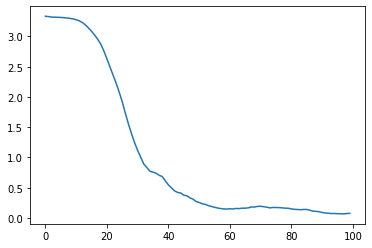

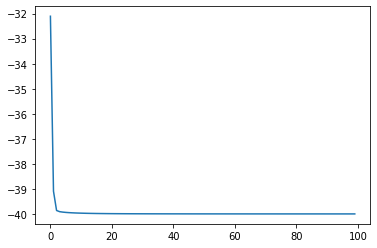

In [10]:
import matplotlib.pyplot as plt

plt.plot(train_history['critic'])
plt.show()
plt.plot(train_history['actor'])

In [11]:
s,r,a,v = next(iter(train_iter))
actions = model.actor_forward(s,r,eval=True)

In [12]:
pd.DataFrame(actions[0].detach().numpy()).style.background_gradient()

,0,1,2,3,4,5,6,7,8,9
0,0.906961,0.337687,0.326640,0.560834,0.948211,0.919681,0.656706,0.961675,0.572444,0.164451
1,0.920438,0.117370,0.947318,0.650810,0.925967,0.444477,0.903031,0.950968,0.439180,0.045292
2,0.754474,0.224740,0.981340,0.835887,0.515166,0.206318,0.947258,0.783217,0.420122,0.067443
3,0.214776,0.851930,0.989362,0.802060,0.059002,0.022968,0.480904,0.296500,0.956327,0.600972
4,0.447872,0.512773,0.186376,0.521431,0.338121,0.864985,0.407555,0.439343,0.449198,0.260360
5,0.704742,0.429593,0.342641,0.259783,0.684759,0.441535,0.551067,0.268083,0.152030,0.548972


In [13]:
values = model.critic_forward(s[0:3],a[0:3],eval=True)
values

tensor([[0.4897],
        [0.3459],
        [0.8275]], grad_fn=<SliceBackward>)